# Disaster Events Detection with PySpark MLlib

### Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover, Tokenizer
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, LinearSVC, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer


### Create a spark session

In [6]:
spark = SparkSession.builder.appName('nlp').getOrCreate()

## Exploring data analysis

#### Load data file

In [7]:
#data
df = spark.read.csv('file:/home/user/folder/Dataset_Disaster.csv', header = True, inferSchema = True)

In [8]:
#show data
df.show()

+---+--------------------+------+--------------------+
| id|                text|target|              tokens|
+---+--------------------+------+--------------------+
|  1|our deeds are the...|     1|['deed', 'reason'...|
|  4|forest fire near ...|     1|['forest', 'fire'...|
|  5|all residents ask...|     1|['resid', 'ask', ...|
|  6| people receive w...|     1|['peopl', 'receiv...|
|  7|just got sent thi...|     1|['got', 'sent', '...|
|  8|rockyfire update ...|     1|['rockyfir', 'upd...|
| 10|flood disaster he...|     1|['flood', 'disast...|
| 13|im on top of the ...|     1|['im', 'top', 'hi...|
| 14|theres an emergen...|     1|['there', 'emerg'...|
| 15|im afraid that th...|     1|['im', 'afraid', ...|
| 16|three people died...|     1|['three', 'peopl'...|
| 17|haha south tampa ...|     1|['haha', 'south',...|
| 18|raining flooding ...|     1|['rain', 'flood',...|
| 19|flood in bago mya...|     1|['flood', 'bago',...|
| 20|damage to school ...|     1|['damag', 'school...|
| 23|     

In [9]:
print("Data Count:",df.count())

Data Count: 10876


In [10]:
# the number of tweets (tokens) for each target (O or 1)
df.toPandas().groupby(['target']).size()

target
0    7605
1    3271
dtype: int64

## Data Preprocessing

In [11]:
# Extract id, tokens and target from datset
df = df.select("id","tokens","target")
df.show(5)

+---+--------------------+------+
| id|              tokens|target|
+---+--------------------+------+
|  1|['deed', 'reason'...|     1|
|  4|['forest', 'fire'...|     1|
|  5|['resid', 'ask', ...|     1|
|  6|['peopl', 'receiv...|     1|
|  7|['got', 'sent', '...|     1|
+---+--------------------+------+
only showing top 5 rows



### Drop missing values

In [12]:
df = df.dropna()
df.count()

10876

###  Removing numbers from the tweet

In [13]:
df = df.withColumn("Tokens",regexp_replace(col('tokens'), '\d+', ''))
df.show(5)

+---+--------------------+------+
| id|              Tokens|target|
+---+--------------------+------+
|  1|['deed', 'reason'...|     1|
|  4|['forest', 'fire'...|     1|
|  5|['resid', 'ask', ...|     1|
|  6|['peopl', 'receiv...|     1|
|  7|['got', 'sent', '...|     1|
+---+--------------------+------+
only showing top 5 rows



### Tokenization +  Lowercase + Remove Special characters

In [14]:
regex_tokenizer = RegexTokenizer(inputCol="Tokens", outputCol="t", pattern="\\W")
raw_words = regex_tokenizer.transform(df)
raw_words.show()

+---+--------------------+------+--------------------+
| id|              Tokens|target|                   t|
+---+--------------------+------+--------------------+
|  1|['deed', 'reason'...|     1|[deed, reason, ea...|
|  4|['forest', 'fire'...|     1|[forest, fire, ne...|
|  5|['resid', 'ask', ...|     1|[resid, ask, shel...|
|  6|['peopl', 'receiv...|     1|[peopl, receiv, w...|
|  7|['got', 'sent', '...|     1|[got, sent, photo...|
|  8|['rockyfir', 'upd...|     1|[rockyfir, updat,...|
| 10|['flood', 'disast...|     1|[flood, disast, h...|
| 13|['im', 'top', 'hi...|     1|[im, top, hill, s...|
| 14|['there', 'emerg'...|     1|[there, emerg, ev...|
| 15|['im', 'afraid', ...|     1|[im, afraid, torn...|
| 16|['three', 'peopl'...|     1|[three, peopl, di...|
| 17|['haha', 'south',...|     1|[haha, south, tam...|
| 18|['rain', 'flood',...|     1|[rain, flood, flo...|
| 19|['flood', 'bago',...|     1|[flood, bago, mya...|
| 20|['damag', 'school...|     1|[damag, school, b...|
| 23|     

### Removing the stop words from raw words

In [15]:
remover = StopWordsRemover(inputCol="t", outputCol="filtered")
words_df = remover.transform(raw_words)
words_df.show(5)

+---+--------------------+------+--------------------+--------------------+
| id|              Tokens|target|                   t|            filtered|
+---+--------------------+------+--------------------+--------------------+
|  1|['deed', 'reason'...|     1|[deed, reason, ea...|[deed, reason, ea...|
|  4|['forest', 'fire'...|     1|[forest, fire, ne...|[forest, fire, ne...|
|  5|['resid', 'ask', ...|     1|[resid, ask, shel...|[resid, ask, shel...|
|  6|['peopl', 'receiv...|     1|[peopl, receiv, w...|[peopl, receiv, w...|
|  7|['got', 'sent', '...|     1|[got, sent, photo...|[got, sent, photo...|
+---+--------------------+------+--------------------+--------------------+
only showing top 5 rows



### Create a features column from the words

In [16]:
cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(words_df)
countVectorizer_train = model.transform(words_df)
countVectorizer_train = countVectorizer_train.withColumn("label",col('target'))
countVectorizer_train.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+
| id|              Tokens|target|                   t|            filtered|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|  1|['deed', 'reason'...|     1|[deed, reason, ea...|[deed, reason, ea...|(25841,[5,115,233...|    1|
|  4|['forest', 'fire'...|     1|[forest, fire, ne...|[forest, fire, ne...|(25841,[2,130,179...|    1|
|  5|['resid', 'ask', ...|     1|[resid, ask, shel...|[resid, ask, shel...|(25841,[47,239,34...|    1|
|  6|['peopl', 'receiv...|     1|[peopl, receiv, w...|[peopl, receiv, w...|(25841,[13,47,56,...|    1|
|  7|['got', 'sent', '...|     1|[got, sent, photo...|[got, sent, photo...|(25841,[52,110,15...|    1|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [17]:
countVectorizer_train.select('tokens','filtered','features','label').show()

+--------------------+--------------------+--------------------+-----+
|              tokens|            filtered|            features|label|
+--------------------+--------------------+--------------------+-----+
|['deed', 'reason'...|[deed, reason, ea...|(25841,[5,115,233...|    1|
|['forest', 'fire'...|[forest, fire, ne...|(25841,[2,130,179...|    1|
|['resid', 'ask', ...|[resid, ask, shel...|(25841,[47,239,34...|    1|
|['peopl', 'receiv...|[peopl, receiv, w...|(25841,[13,47,56,...|    1|
|['got', 'sent', '...|[got, sent, photo...|(25841,[52,110,15...|    1|
|['rockyfir', 'upd...|[rockyfir, updat,...|(25841,[2,56,110,...|    1|
|['flood', 'disast...|[flood, disast, h...|(25841,[21,23,67,...|    1|
|['im', 'top', 'hi...|[im, top, hill, s...|(25841,[2,6,38,19...|    1|
|['there', 'emerg'...|[emerg, evacu, ha...|(25841,[20,24,47,...|    1|
|['im', 'afraid', ...|[im, afraid, torn...|(25841,[6,41,293,...|    1|
|['three', 'peopl'...|[three, peopl, di...|(25841,[13,120,16...|    1|
|['hah

### Separate the Train and Validation Data

In [18]:
(train, validate) = countVectorizer_train.randomSplit([0.85, 0.15], seed=1)

## Machine Learning Prediction Models

### Naive Bayes Classifier

In [19]:
nb = NaiveBayes(modelType="multinomial",labelCol="label", featuresCol="features")
nbModel = nb.fit(train)

In [20]:
#train data
nb_predictions = nbModel.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("NaiveBayes Accuracy for train data = %g"% (nb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("NaiveBayes Recall for train data = %g"% (nb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
nb_F1 = evaluator.evaluate(nb_predictions)
print("NaiveBayes F1 score for train data  = %g"% (nb_F1))

nbEval = BinaryClassificationEvaluator()
print('Area Under ROC for train data= ', nbEval.evaluate(nb_predictions))

NaiveBayes Accuracy for train data = 0.882113
NaiveBayes Recall for train data = 0.882851
NaiveBayes F1 score for train data  = 0.882424
Area Under ROC for train data=  0.47934059762277015


In [23]:
#test data
nb_predictions = nbModel.transform(validate)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("NaiveBayes Accuracy for test data = %g"% (nb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("NaiveBayes Recall for test data = %g"% (nb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
nb_F1 = evaluator.evaluate(nb_predictions)
print("NaiveBayes F1 score for test data  = %g"% (nb_F1))

nbEval = BinaryClassificationEvaluator()
print('Area Under ROC for test data = ', nbEval.evaluate(nb_predictions))

NaiveBayes Accuracy for test data = 0.755924
NaiveBayes Recall for test data = 0.757393
NaiveBayes F1 score for test data  = 0.756629
Area Under ROC for test data =  0.4541569314641751


### Logistic Regression Model

In [22]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target', maxIter=10)
lrModel = lr.fit(train)

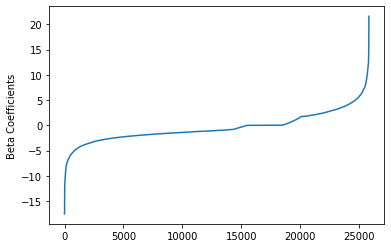

In [185]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

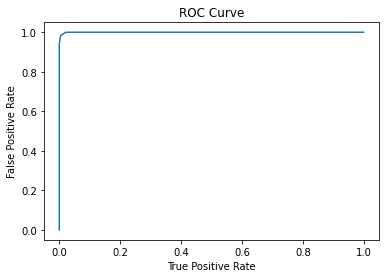

In [186]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


#### Precision and recall

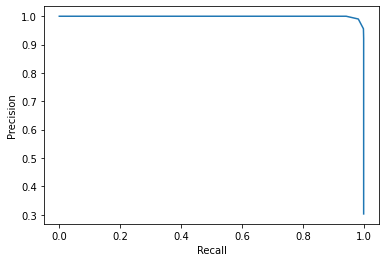

In [187]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Evaluate the Logistic Regression model

In [205]:
#train data
lrPreds = lrModel.transform(train)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lrPreds)
print("Logistic Regression Accuracy of train data = %g"% (lr_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
lr_recall = evaluator.evaluate(lrPreds)
print("Logistic Regression Recall of train data = %g"% (lr_recall))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_recall = evaluator.evaluate(lrPreds)
print("Logistic Regression f1 of train data = %g"% (lr_recall))

lrEval = BinaryClassificationEvaluator()
print('Train Area Under ROC', lrEval.evaluate(lrPreds))


Logistic Regression Accuracy of train data = 0.991756
Logistic Regression Recall of train data = 0.991756
Logistic Regression f1 of train data = 0.991758
Train Area Under ROC 0.9997961322028737


In [207]:
#test data
lrPreds = lrModel.transform(validate)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lrPreds)
print("Logistic Regression Accuracy of test data = %g"% (lr_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
lr_recall = evaluator.evaluate(lrPreds)
print("Logistic Regression Recall of test data = %g"% (lr_recall))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_recall = evaluator.evaluate(lrPreds)
print("Logistic Regression f1 of test data = %g"% (lr_recall))

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))


Logistic Regression Accuracy of test data = 0.7242
Logistic Regression Recall of test data = 0.7242
Logistic Regression f1 of test data = 0.712381
Test Area Under ROC 0.6935163551401841


### Decision Tree Classifier

In [190]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(validate)
dtPreds.select("probability","prediction","target").show()

+--------------------+----------+------+
|         probability|prediction|target|
+--------------------+----------+------+
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     0|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
|[0.71808510638297...|       0.0|     1|
+--------------------+----------+------+
only showing top

In [203]:
#train data

dtPreds = dtModel.transform(train)
predictions=dtPreds
# Select example rows to display.
predictions.select("prediction", "target", "features").show(5)

# Select (prediction, true label) and compute test error
acc = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = acc.evaluate(predictions)
print("Decision Tree accuracy of train data = %g " %  accuracy)

rec = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="weightedRecall")
recall = rec.evaluate(predictions)
print("Decision Tree recall of train data = %g " %  recall)

F1 = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="f1")
f1_score = F1.evaluate(predictions)
print("Decision Tree F1 score of train data = %g " %  f1_score)

DTEval = BinaryClassificationEvaluator()
print('Desicion Tree Train Area Under ROC', DTEval.evaluate(dtPreds))

+----------+------+--------------------+
|prediction|target|            features|
+----------+------+--------------------+
|       0.0|     0|(25841,[22,57,173...|
|       0.0|     1|(25841,[5,115,233...|
|       0.0|     0|(25841,[153,233,2...|
|       0.0|     0|(25841,[2,124,130...|
|       0.0|     1|(25841,[47,239,34...|
+----------+------+--------------------+
only showing top 5 rows

Decision Tree accuracy of train data = 0.712225 
Decision Tree recall of train data = 0.712225 
Decision Tree F1 score of train data = 0.637706 
Desicion Tree Train Area Under ROC 0.4533856212195971


In [204]:
#test data

dtPreds = dtModel.transform(validate)
predictions=dtPreds
# Select example rows to display.
predictions.select("prediction", "target", "features").show(5)

# Select (prediction, true label) and compute test error
acc = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = acc.evaluate(predictions)
print("Decision Tree accuracy of test data = %g " %  accuracy)

rec = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="weightedRecall")
recall = rec.evaluate(predictions)
print("Decision Tree recall of test data = %g " %  recall)

F1 = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="f1")
f1_score = F1.evaluate(predictions)
print("Decision Tree F1 score of test data = %g " %  f1_score)

DTEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', DTEval.evaluate(dtPreds))

+----------+------+--------------------+
|prediction|target|            features|
+----------+------+--------------------+
|       0.0|     1|(25841,[2,130,179...|
|       0.0|     1|(25841,[21,23,67,...|
|       0.0|     1|(25841,[22,57,162...|
|       0.0|     0|(25841,[520,1025]...|
|       0.0|     0|(25841,[15011],[1...|
+----------+------+--------------------+
only showing top 5 rows

Decision Tree accuracy of test data = 0.724804 
Decision Tree recall of test data = 0.724804 
Decision Tree F1 score of test data = 0.658536 
Test Area Under ROC 0.44590147975077876


### Random Forest

In [221]:

# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(countVectorizer_train)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="p", maxCategories=4).fit(countVectorizer_train)



# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=40)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


In [222]:

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

In [223]:
# train data
predictions = model.transform(train)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Random Forest accuracy for train data = %g" % (accuracy))

rec = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="weightedRecall")
recall = rec.evaluate(predictions)
print("Random Forest recall for train data = %g " %  recall)

F1 = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="f1")
f1_score = F1.evaluate(predictions)
print("Random Forest F1 score for train data = %g " %  f1_score)

rfEval = BinaryClassificationEvaluator()
print('Train Area Under ROC', rfEval.evaluate(predictions))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|(25841,[22,57,173...|
|             0|    1|(25841,[5,115,233...|
|             0|    0|(25841,[153,233,2...|
|             0|    0|(25841,[2,124,130...|
|             0|    1|(25841,[47,239,34...|
+--------------+-----+--------------------+
only showing top 5 rows

Random Forest accuracy for train data = 0.697256
Random Forest recall for train data = 0.697256 
Random Forest F1 score for train data = 0.572884 
Train Area Under ROC 0.7854128536095994
RandomForestClassificationModel (uid=RandomForestClassifier_2a0e86263e53) with 80 trees


In [224]:
# test data
predictions = model.transform(validate)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Random Forest accuracy for test data = %g" % (accuracy))

rec = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="weightedRecall")
recall = rec.evaluate(predictions)
print("Random Forest recall for test data = %g " %  recall)

F1 = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="f1")
f1_score = F1.evaluate(predictions)
print("Random Forest F1 score for train data = %g " %  f1_score)

rfEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', rfEval.evaluate(predictions))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    1|(25841,[2,130,179...|
|             0|    1|(25841,[21,23,67,...|
|             0|    1|(25841,[22,57,162...|
|             0|    0|(25841,[520,1025]...|
|             0|    0|(25841,[15011],[1...|
+--------------+-----+--------------------+
only showing top 5 rows

Random Forest accuracy for test data = 0.71032
Random Forest recall for test data = 0.71032 
Random Forest F1 score for train data = 0.590012 
Test Area Under ROC 0.728368380062306
RandomForestClassificationModel (uid=RandomForestClassifier_2a0e86263e53) with 80 trees


## Gradient-boosted tree classifier

In [231]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(validate)
predictions.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| id|              Tokens|target|                   t|            filtered|            features|label|       rawPrediction|         probability|prediction|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|  4|['forest', 'fire'...|     1|[forest, fire, ne...|[forest, fire, ne...|(25841,[2,130,179...|    1|[0.29770063852702...|[0.64460348753227...|       0.0|
| 10|['flood', 'disast...|     1|[flood, disast, h...|[flood, disast, h...|(25841,[21,23,67,...|    1|[-0.1453725512293...|[0.42782146344345...|       1.0|
| 20|['damag', 'school...|     1|[damag, school, b...|[damag, school, b...|(25841,[22,57,162...|    1|[0.53259782824034...|[0.74368218937526...|       0.0|
| 32|  ['london', 'cool']|     0|      [london, cool]|      [lon

In [234]:
#test data

gbtEval = BinaryClassificationEvaluator() 

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
gb_accuracy = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier Accuracy for test data = %g"% (gb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall") 
recall = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier Recall for test data = %g"% (recall))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1") 
f1 = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier F1 score for test data = %g"% (f1))

gbtROC = gbtEval.evaluate(predictions, {gbtEval.metricName: "areaUnderROC"}) 
print("Test Area Under ROC: " + str(gbtROC))

Gradient-boosted tree classifier Accuracy for test data = 0.732649
Gradient-boosted tree classifier Recall for test data = 0.732649
Gradient-boosted tree classifier F1 score for test data = 0.675338
Test Area Under ROC: 0.6830678278108183


In [235]:
predictions = gbtModel.transform(train)
gbtEval = BinaryClassificationEvaluator() 

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
gb_accuracy = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier Accuracy for train data = %g"% (gb_accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall") 
recall = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier Recall for train data = %g"% (recall))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1") 
f1 = evaluator.evaluate(predictions) 
print("Gradient-boosted tree classifier F1 score for train data = %g"% (f1))

gbtROC = gbtEval.evaluate(predictions, {gbtEval.metricName: "areaUnderROC"}) 
print("Train Area Under ROC: " + str(gbtROC))

Gradient-boosted tree classifier Accuracy for train data = 0.733377
Gradient-boosted tree classifier Recall for train data = 0.733377
Gradient-boosted tree classifier F1 score for train data = 0.673919
Train Area Under ROC: 0.7281076363999585
